### Flat Earth Gravity Simulation
**Jonathan Zerez, Spring 2021**

This notebook is a simulation of what gravity would be like if the earth was flat. Because the earth isn't actually flat, there are a number of key assumptions I made in the creaiton of this model, which are as follows:
* The Universal Gravitational Constant is the same $\left(6.67 \times 10^{-11} \frac{\text{N} \cdot \text{m}^2}{\text{kg}^2} \right)$
* The radius of flat earth is twice the radius of sphereical earth (This keeps the surface areas between the two earths equal)
* The mass of flat earth is the same as the mass of the real earth ($5.97 \times 10^{24} \text{ kg}$)
* The thickness of flat earth is 1/10 the radius of flat earth. 

The coordinate system used in this simulation is cylindrical. `x` refers to the radius of a given point (ie: distance to origin), and `z` refers to the height of a given point, with the surface of the flat earth as the origin. 

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Universal Grativational Constant
G = 6.67e-11 
# Radius of real earth
re_real = 6371e3
# Radius of flat earth
re = 2 * re_real
# Mass of flat earth
me = 5.972e24
# Thickness of flat earth
t = re / 10


def calc_y(r_total, r):
    """
    If a circle is defined as x^2 + y^2 = r^2,
    This function returns the y value for a given x.
    
    Parameters:
        r_total (float): The total radius of the circle
        r       (float): The distance from the origin (x coordinate)
    
    Returns:
        y       (float): The corresponding y value
    """
    y = 2 * np.sqrt(r_total**2 - r**2)
    return y
    
def unit(v):
    """
    Normalizes vector v into a unit vector
    """
    return v / np.linalg.norm(v, axis=0)


def make_linear_mesh(r_total, m_total, t, size, debug=False):
    """
    Creates a linear mesh of flat earth
    
    Parameters:
        r_total (float): Radius of flat earth in meters
        m_total (float): Mass of flat earth in kilograms
        t       (float): Thickness of flat earth in meters
        size      (int): The size of each element in the mesh in meters  
        debug    (bool): Toggles debugging print statements
    """
    # Volume of flat earth
    v_total = np.pi * r_total**2 * t
    # The locations of the borders of each linear mesh element
    bounds = np.linspace(-r_total, r_total, int(2*r_total // size))
    # The size of each linear mesh element
    sizes = np.diff(bounds)
    # The location (midpoint) of each linear mesh element
    locs = bounds[:-1] + (sizes / 2)
    
    # The volume of each linear mesh element
    vs = calc_y(r_total, locs) * sizes * t
    # The mass of each linear mesh element
    ms = vs / v_total * m_total
    
    # the center of mass of each linear mesh element in 2d space
    mass_locs = np.vstack((locs, np.ones_like(locs) * -t/2))
    
    # Compares approximated mass and volume to actual mass and volume
    if debug:
        v_error = abs(np.sum(vs) - v_total) / v_total * 100
        m_error = abs(np.sum(ms) - m_total) / m_total * 100
        print("Mesh volume is {:.2e}".format(v_error), " % off")
        print("Mesh mass is {:.2e}".format(v_error), " % off")
    return ms, mass_locs



def calc_grav(pos, m, ms, mass_locs, debug=False):
    """
    Calculates the gravity flat earth exerts on a mass given its location
    
    Parameters
        pos ((2,) np.array): The position of the mass in x,z coordinates (meters)
        m           (float): The mass of the object (kg)
        ms  ((n,) np.array): The magnitudes of masses in the linear mesh
        mass_locs ((n,2) np.array): The x,z locations of each linear mesh element
        debug        (bool): Toggles debugging print statement
    
    Returns:
        F_grav ((2,) np.array): The gravity vector.
    """
    # Calculate distance vector to each of the linear mesh elements
    rs = mass_locs - pos

    # Calculate the distance to each of the linear mesh elements
    r_mags = np.linalg.norm(rs, axis=0)
    # Calculate gravitational force due to each element
    Fs = ms * m * G * unit(rs) / r_mags**2
    
    # Calculate the total gravitional force
    F_grav = np.sum(Fs, axis=1)
    if debug:
        plt.quiver(mass_locs[0, :], mass_locs[1, :]+t/2, Fs[0, :], Fs[1,:], units='xy')
        plt.plot(pos[0], pos[1], 'r*', markersize=10)
        
        plt.xlim([-re,re])
        plt.quiver(pos[0], pos[1], F_grav[0], F_grav[1], color='b')
        plt.legend(['Object locaiton','Individual Gravity Vectors', 'Net gravitational force'])
        plt.title('')
        plt.ylabel('z (Vertical Distance from surface in meters)')
        plt.xlabel('x (Radial Distance from north pole in meters)')
    return F_grav

### Running the simulation!
Below is an example of the individual gravity vectors due to each linear mesh element. 

Mesh volume is 9.82e-04  % off
Mesh mass is 9.82e-04  % off


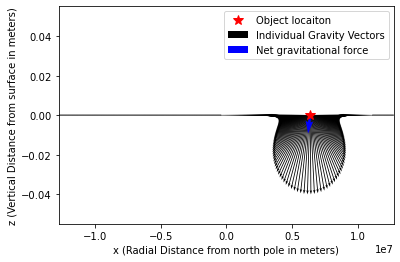

In [27]:
ms, locs = make_linear_mesh(re, me, t, re//500, 1)

# Create a point on the surface of flat earth, on the "equator"
pos = np.array([re*0.5, 0]).reshape(2,1)
m = 1

F_grav = calc_grav(pos, m, ms, locs, 1)


It is a bit hard to see, but notice how the blue vector, which is the net gravitaional force for the point, is not pointing straight into the ground! Lets see what the net gravity is as we move along the radius of flat earth.

In [22]:
num_x = 100
xs = np.linspace(0, 1.1 * re, num_x)

# Angle of gravity
ts = np.zeros_like(xs)
# Magnitude of gravity
mags = np.zeros_like(xs)
# gravity vectors
fs = np.zeros([2, len(xs)])

for i, x in enumerate(xs):
    pos = np.array([x, 0*re]).reshape(2,1)
    f = calc_grav(pos, m, ms, locs)
    ts[i] = -np.arctan2(f[1], f[0])* 180 / np.pi -90
    mags[i] = np.linalg.norm(f)
    fs[:,i] = f

79.9569064347759


Text(0.5, 1.0, 'Gravity vs. Distance from North Pole')

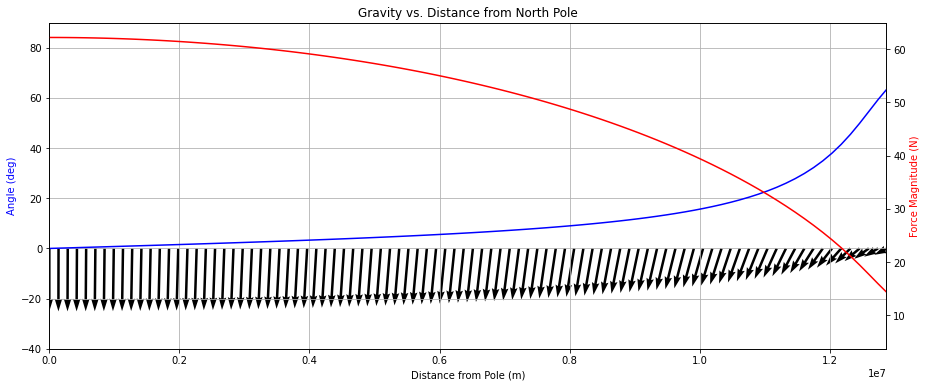

In [25]:
fig, ax1 = plt.subplots()

ax1.plot(xs, ts, 'b-')
ax1.set_xlabel('Distance from Pole (m)')
ax1.set_ylabel('Angle (deg)', color='b')
ax1.grid()
ax1.quiver(xs, np.zeros_like(xs), fs[0, :], fs[1, :], width=0.003)
ax2 = ax1.twinx()
ax2.set_ylabel('Force Magnitude (N)', color='r')
ax2.plot(xs, mags, 'r-')
print(max(ts))
ax1.set_xlim([0, re*1.01])
ax1.set_ylim([-40, 90])
fig.set_size_inches(15, 6)
plt.title('Gravity vs. Distance from North Pole')


**What is this graph showing?**

The black arrows are individual gravity vectors. The arrow at a given locations shows the angle and relative magnitude of gravity that would be felt by a 1kg object placed at that location. Gravity's magnitude and angle seem to be relatively constant near the pole, but become quite bizzare as one approaches the edge of flat earth. 

The blue line represents the angle that gravity acts in with respect to the normal to the ground (ie: 0 degrees is perfectly vertical and 90 degrees is perfectly horizontal). The blue line shows that at the center and up until around the equator, the angle of gravity is more or less vertical. However, past around 8 million meters from the north pole, the angle with respect to the ground tends to increase a lot.

The red line represents the magnitude of the gravity vector at different locations. Similar to the blue line, the magnitude of force is pretty constant when you're close to the pole. But as you move farther and farther away, the magnitude of gravity becomes smaller and smaller.